In [1]:
import pandas as pd
from pandas import DataFrame, Series
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import OrderedDict
import pytz
import sys

In [2]:
print ('Python Version: {}'.format(sys.version))
print ('Pandas Version: {}'.format(pd.__version__))
print ('Matplotlib Version: {}'.format(matplotlib.__version__))
print ('Seaborn Version: {}'.format(sns.__version__))

Python Version: 3.6.1 |Anaconda 4.4.0 (x86_64)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
Pandas Version: 0.20.1
Matplotlib Version: 2.0.2
Seaborn Version: 0.7.1


#### Obtain apple health data from the 'Health' app, navigating to your profile icon, and then clicking 'Export Health Data'.
#### Read in Stepcount.CSV (converted from xml to csv using the applehealthdata.py script - https://github.com/tdda/applehealthdata) to a Pandas DataFrame

In [3]:
df = pd.read_csv("data/StepcountExample.csv")

In [4]:
df[:5]

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
0,iPhone,NaN,NaN,StepCount,count,2015-08-18 6:54:21 pm +0000,2015-08-18 6:22:56 pm +0000,2015-08-18 6:26:25 pm +0000,74
1,iPhone,NaN,NaN,StepCount,count,2015-08-18 7:54:03 pm +0000,2015-08-18 6:57:16 pm +0000,2015-08-18 6:59:30 pm +0000,93
2,iPhone,NaN,NaN,StepCount,count,2015-08-18 7:54:03 pm +0000,2015-08-18 7:14:27 pm +0000,2015-08-18 7:18:41 pm +0000,85
3,iPhone,NaN,NaN,StepCount,count,2015-08-18 7:54:03 pm +0000,2015-08-18 7:28:48 pm +0000,2015-08-18 7:33:20 pm +0000,41
4,iPhone,NaN,NaN,StepCount,count,2015-08-18 8:58:31 pm +0000,2015-08-18 7:49:37 pm +0000,2015-08-18 7:51:01 pm +0000,22


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47836 entries, 0 to 47835
Data columns (total 9 columns):
sourceName       47836 non-null object
sourceVersion    39515 non-null object
device           39515 non-null object
type             47836 non-null object
unit             47836 non-null object
creationDate     47836 non-null object
startDate        47836 non-null object
endDate          47836 non-null object
value            47836 non-null int64
dtypes: int64(1), object(8)
memory usage: 3.3+ MB


#### There's a lot of 'junk' columns we're not really interested in here, so -> create new DataFrame of just the start and end datetimes of an 'activity' 
#### Convert these to type datetime and rename to something more 'friendly' to use/type

In [6]:
new = df[['startDate', 'endDate']].copy()

In [7]:
new['startDate'] = pd.to_datetime(new.startDate)

In [8]:
new['endDate'] = pd.to_datetime(new.endDate)

In [9]:
new.columns = ['start','end']

In [10]:
new = new.reset_index(drop=True)


In [11]:
new['date'] = pd.to_datetime(new['start'].dt.date)

In [12]:
new[:5]

,start,end,date
0,2015-08-18 18:22:56,2015-08-18 18:26:25,2015-08-18
1,2015-08-18 18:57:16,2015-08-18 18:59:30,2015-08-18
2,2015-08-18 19:14:27,2015-08-18 19:18:41,2015-08-18
3,2015-08-18 19:28:48,2015-08-18 19:33:20,2015-08-18
4,2015-08-18 19:49:37,2015-08-18 19:51:01,2015-08-18


#### Now the data is ready to do some slightly more complicated stuff with. There's quite a few ways to go from here, but I'm going to find the last value for day <i>i</i> and the first value of day <i>i+1</i>. For now this has the constraint that 12pm that can be the latest value for day <i>i</i>. I will then calculate the difference between the two, which I will assume is a good indicator of the amount of time spent asleep.

### To work out difference between last value on current day and first on next day:

In [13]:
begin = new.date[0]
i=0
sleep = DataFrame([])
total_days = new.groupby('date')['date'].nunique().sum()   # The total number of days in this data

while i < total_days:
    # first value for day i+1 minus the last value for day i and append to a dataframe
    calc = Series([new.loc[new['date'] == begin+timedelta(i+1)].start.min() - new.loc[new['date'] == begin+timedelta(i)].end.max()])
    sleep = sleep.append(calc, ignore_index = True)
    
    i+=1
    

#### In short, what just happened here - 'Locked on a date', found the last value for this date, found the first value for this date +1, and subtracted the two, resulting in a time of type timedelta. This process is repeated for the entire 'raw' dataset with the calculated time difference added as a column to the dataframe 'sleep'

#### Now, tidy this 'sleep' dataframe by renaming the column and creating a column entitled 'hours' of type float -> which will be useful for plotting purposes later on.

In [14]:
sleep.columns = ['sleep_time']

In [15]:
sleep.dtypes

sleep_time    timedelta64[ns]
dtype: object

In [16]:
sleep['hours'] = sleep['sleep_time'] / np.timedelta64(3600, 's')

#### Assign a date to the data series:

In [17]:
sleep['date'] = pd.Series(pd.date_range(begin, periods =new.groupby('date')['date'].nunique().sum()))

In [18]:
sleep[:5]

,sleep_time,hours,date
0,11:49:12,11.820000,2015-08-18
1,00:05:03,0.084167,2015-08-19
2,09:12:25,9.206944,2015-08-20
3,10:06:52,10.114444,2015-08-21
4,07:08:00,7.133333,2015-08-22


### To work out first value of the day:
#### [This isn't explicity used here, but could be an interesting metric to look at in more detail later...]

In [19]:
i=0
firstval = DataFrame()
total_days = new.groupby('date')['date'].nunique().sum() #need a way to calculate this
while i < total_days:
    calc2 = Series(new.loc[new['date'] == begin+timedelta(i)].start.min())
    #print firstval
    firstval = firstval.append(calc2, ignore_index = True)

    i+=1

In [20]:
firstval[:5]

,0
0,2015-08-18 18:22:56
1,2015-08-19 07:58:05
2,2015-08-20 00:02:16
3,2015-08-21 06:14:35
4,2015-08-22 09:13:12


#### Add this to the 'sleep' dataframe and rename. Add a day of week column.

In [21]:
sleep = pd.concat([sleep, firstval], axis=1)

In [22]:
sleep.columns.values[3] = "first_val"

##### day of week is assigned a numerical value

In [23]:
sleep['day'] = sleep['date'].dt.dayofweek

In [24]:
sleep[:5]

,sleep_time,hours,date,first_val,day
0,11:49:12,11.820000,2015-08-18,2015-08-18 18:22:56,1
1,00:05:03,0.084167,2015-08-19,2015-08-19 07:58:05,2
2,09:12:25,9.206944,2015-08-20,2015-08-20 00:02:16,3
3,10:06:52,10.114444,2015-08-21,2015-08-21 06:14:35,4
4,07:08:00,7.133333,2015-08-22,2015-08-22 09:13:12,5


#### Since the 'hours' column derives from the last value of day <i>i</i> and the first value of day <i>i+1</i>, days when steps were taken shortly after midnight [i.e. I didn't sleep before midnight] results in a false amount of 'innactive' hours. These days can be quickly filtered out:

In [25]:
sleep = sleep[(sleep['hours']>3)]

#### Plot the 'raw' innactive hours against time, i.e. for each day:

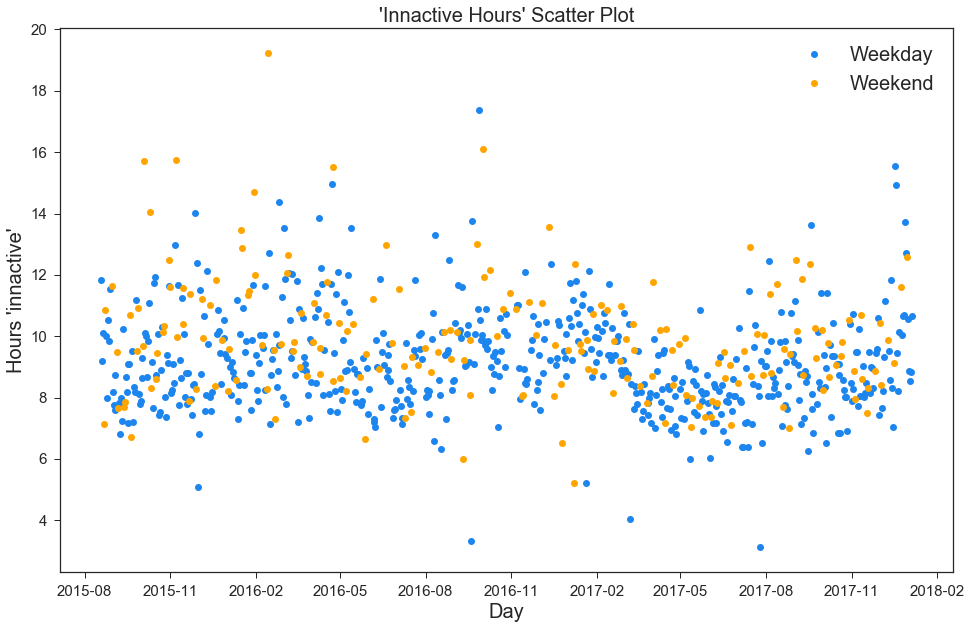

In [26]:
a4_dims=(16,10)
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=a4_dims)

for key, row in sleep[(sleep['day']<5)].groupby('date'):  # Weekday hours plotted in blue
    
    ax.plot( key, row['hours'], 'o', label='Weekday', color='#1C86EE')
    
for key, row in sleep[(sleep['day']>4)].groupby('date'):  # Weekend hours plotted in red
    
    ax.plot(key, row['hours'], 'o', label='Weekend', color='orange')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), prop={'size': 20})
plt.xlabel('Day', size=20)
plt.ylabel('Hours \'innactive\'', size=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title("'Innactive Hours' Scatter Plot", 
          loc="center", size=20)

#plt.savefig('plot_1.png') # Uncomment this to save the figure

#### So although this is displaying all the raw data, it's hard to gain any real insight from this. It's hard to distingish any difference between weekdays and the weekend. There does appear to be a drop off in hours around March 2017, but it's hard to tell for definite. The most that can be reliably drawn from this is that most of my 'innactive' hours are between 7 and 11 hours a day.

##### There's a lot of data to analyse here - so my next step was to just look at my 2017 data.
##### Also, Instead of just focusing on my innactive hours during the night, I wanted to look at every single recorded activity.



In [27]:
df2 = new[(new['date']>'2017-01-01')&(new['date']<'2017-12-31')]

##### Since the data doesn't take into account daylight saving I need to make the dateime value 'aware' of the timezone in which it was recorded, thus all data should be consitent throughout the year

In [29]:
tz = pytz.timezone("Europe/London")
UTC = pytz.utc

df2['start'] = df2['start'].apply(lambda x : x.tz_localize(UTC).tz_convert(tz))
df2['end'] = df2['end'].apply(lambda x : x.tz_localize(UTC).tz_convert(tz))

/Applications/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Applications/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


##### calculate the time difference between the activity ‘start’ and ‘end’ time for all values and convert this value to a float:

In [30]:
df2['act'] = df2.end - df2.start

df2['hours'] = df2['act'] / np.timedelta64(3600, 's')

/Applications/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
df2['time']=df2['start'].dt.hour + df2['start'].dt.minute/60

df2.index =df2.time # This is a bit of hack setting the index to 'time', but is needed for the plot

/Applications/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
df2['day'] = df2['date'].dt.dayofweek

/Applications/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


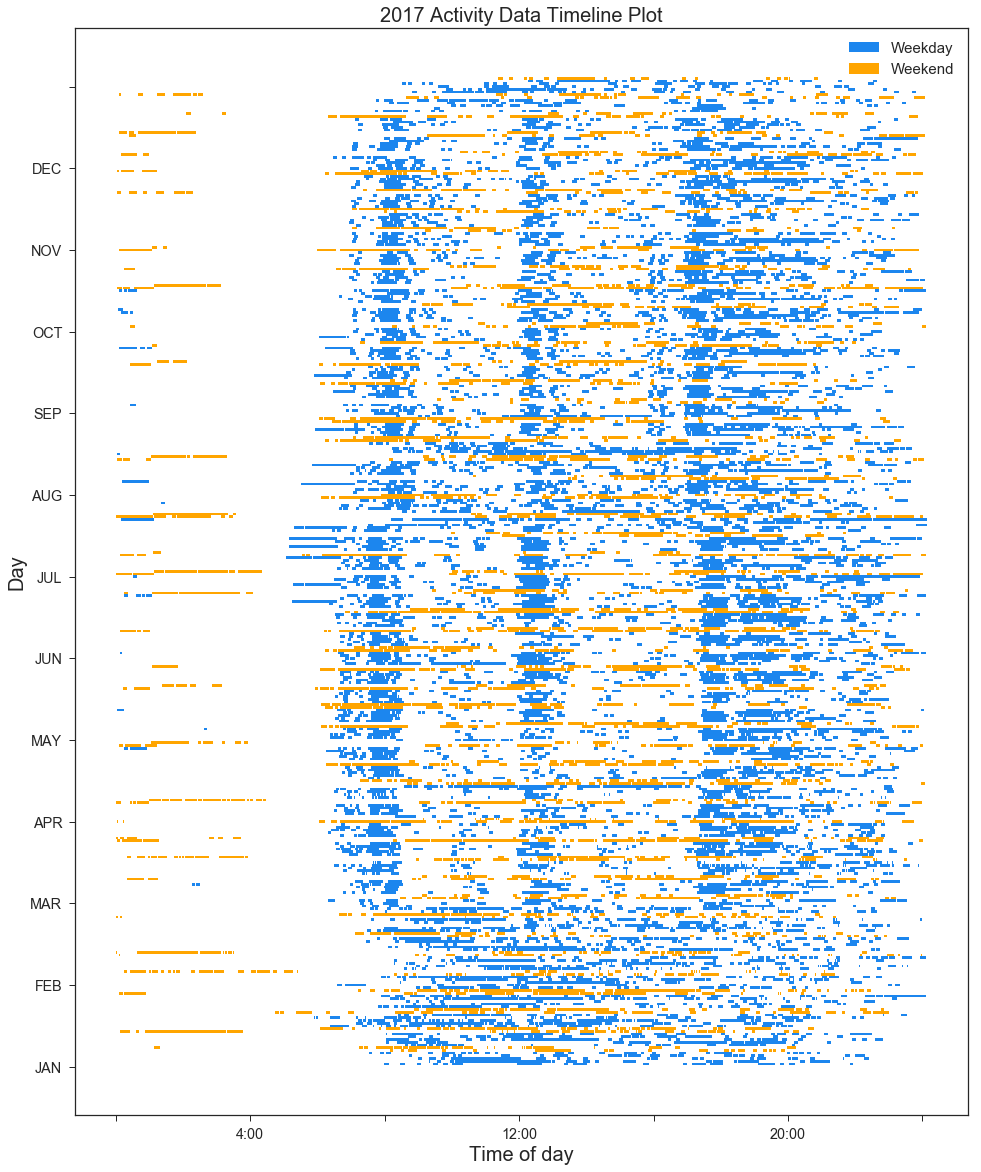

In [33]:
a4_dims=(16,20)
sns.set(style="ticks")

fig, ax = plt.subplots(figsize=a4_dims)

i=2
for key, row in df2.groupby('date'):
    
    if row['day'].values[0] <5:
        ax.broken_barh([tuple(x) for x in pd.DataFrame(row['hours']).to_records()], (i, 2), facecolors='#1C86EE', label='Weekday')
    else:
        ax.broken_barh([tuple(x) for x in pd.DataFrame(row['hours']).to_records()], (i, 2), facecolors='orange',label='Weekend')
    i+=2

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
   
#ax.xaxis.set_ticks(np.arange(2,24.1,2))               # Uncomment these labels for a full x-axis label (and comment out the below x-tick commands)
#xlabels = ['2:00', '4:00', '6:00', '8:00', '10:00','12:00', '14:00',
          #'16:00', '18:00', '20:00', '22:00', '24:00']
#ax.set_xticklabels(xlabels)

ax.yaxis.set_ticks(np.arange(1,738,60)) 
ylabels = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN','JUL', 'AUG',
          'SEP', 'OCT', 'NOV', 'DEC']
ax.set_yticklabels(ylabels) 

ax.xaxis.set_ticks(np.arange(0,24.1,4))
ax.set_xticklabels(['','4:00','','12:00','','20:00'])

plt.legend(by_label.values(), by_label.keys(), prop={'size': 15}) 
plt.xlabel('Time of day', size=20)
plt.ylabel('Day', size=20)
plt.xticks(size='large')
plt.yticks(size='large')
plt.title("2017 Activity Data Timeline Plot", 
          loc="center", size=20)

#plt.savefig('activity.png') #Uncomment this to save

#### So now it's time to delve into this data a little deeper, firstly by grouping by days of the week and plotting with seaborn:

In [34]:
sleep.groupby('day')['hours'].describe()

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
0,121.0,9.345500,1.555207,3.332222,8.226111,9.164167,10.088889,15.536389
1,123.0,8.846206,1.668944,5.097500,7.810278,8.367500,9.540833,17.358611
2,120.0,8.924676,1.462267,3.128611,7.989722,8.927222,9.690139,13.513611
3,119.0,9.187780,1.440827,6.395833,8.287083,9.081111,9.982778,14.376667
4,92.0,9.451259,1.993858,5.204444,8.164236,9.385000,10.755417,14.972222
5,75.0,9.751719,2.207444,5.213333,8.221806,9.532222,10.690278,16.105556
6,121.0,9.918483,1.770043,6.531944,8.695000,9.718333,10.932500,19.235278


##### colours ordered for plot

In [35]:
cols = [(0.32628988850442137, 0.61862360630526725, 0.80279892349096504),
        (0.044059976931949255, 0.33388696655132638, 0.62445213379469444),
        (0.16696655132641292, 0.48069204152249134, 0.72915032679738567),
        (0.32628988850442137, 0.61862360630526725, 0.80279892349096504),
        (0.53568627450980388, 0.74608227604767396, 0.8642522106881968),
        (0.73094963475586316, 0.83947712418300646, 0.92132256824298342),
        (0.85840830449826988, 0.91344867358708182, 0.9645674740484429)
       ]

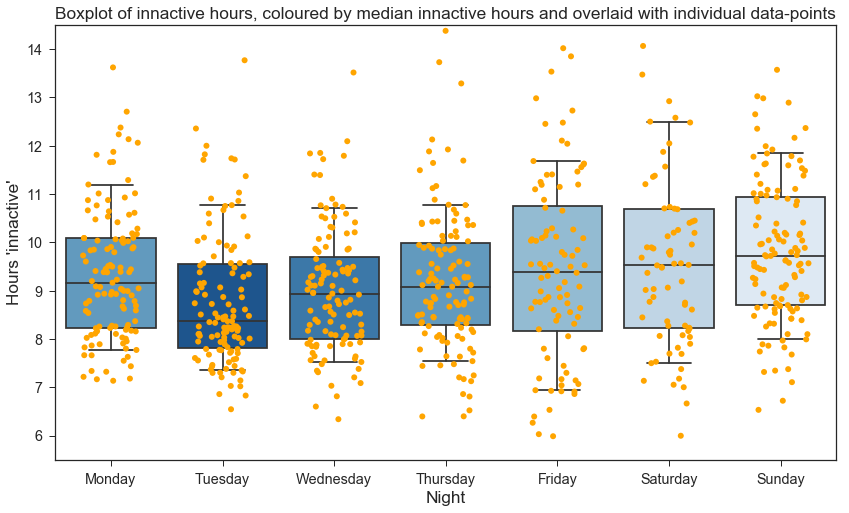

In [46]:
a4_dims=(14,8)
sns.set(style="ticks")
fig, ax = plt.subplots(figsize=a4_dims)

ax = sns.boxplot(x='day',y='hours', data=sleep, whis=[10,90], palette=cols, showfliers=False)
ax = sns.stripplot(x='day',y='hours', data=sleep, color="orange", jitter=0.25, size=6)
plt.title("Boxplot of innactive hours, coloured by median innactive hours and overlaid with individual data-points", 
          loc="left", size='x-large')

ax.set_xticklabels(['Monday', 'Tuesday','Wednesday', 'Thursday','Friday','Saturday','Sunday'])
ax.set_ylim(5.5, 14.5)
plt.xlabel('Night', size='x-large')
plt.ylabel('Hours \'innactive\'', size='x-large')
plt.xticks(size='large')
plt.yticks(size='large')

plt.savefig('plot_3.png')
plt.show()


#### I won't go into too much detail with analysis, but what's intially evident from this is there are some very clear differences between day (or night) of the week and number of 'innactive' hours. Suprisingly, apparently, I have (roughly) an hour less sleep on Tuesday nights compared to Friday nights on average. Saturday has the largest spread of the interquartile range, suggesting less 'routine' sleeping patterns.

### Applying this same methodology, but grouping by months for 2017:

In [37]:
sleep2 = sleep[(sleep['date']>'2017-01-01')&(sleep['date']<'2017-12-31')]

In [38]:
sleep2.groupby('day')['hours'].describe()

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
0,52.0,9.243697,1.634951,7.134167,8.059306,9.067639,9.921458,15.536389
1,52.0,8.885182,1.456315,6.544722,8.060000,8.530972,9.342986,14.918333
2,52.0,8.622484,1.455192,3.128611,7.900000,8.596528,9.465347,11.849444
3,51.0,8.749564,1.373682,6.395833,8.030139,8.445000,9.350000,13.727222
4,39.0,8.536140,1.993048,5.204444,6.932639,8.313333,9.846528,12.726111
5,33.0,9.429192,1.765656,5.213333,8.163333,9.557500,10.401389,12.920278
6,51.0,9.353491,1.254427,7.105278,8.448889,9.115278,10.047778,12.364167


In [39]:
grouped = (sleep2
    .groupby('day')                
    .apply(lambda g:               # work on groups of col1
        g.set_index('date')        
        [['hours']]
        .resample('M', how='mean')  # sum the amount field across weeks
    )
    .unstack(level=0)              # pivot the col1 index rows to columns
    .fillna(0)
)
grouped.columns=grouped.columns.droplevel() 

/Applications/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  


In [40]:
grouped[:5]

day,0,1,2,3,4,5,6
date,,,,,,,
2017-01-31,11.110500,10.781944,9.801181,9.608056,8.196806,8.889722,9.922292
2017-02-28,9.461389,9.746597,10.078819,9.910347,9.865000,8.676667,10.671458
2017-03-31,8.004097,8.472917,7.391278,8.717333,8.539630,10.148611,8.605972
2017-04-30,8.513264,7.929444,7.708542,8.192917,8.631389,8.480370,10.068333
2017-05-31,8.752611,8.198611,8.440278,8.178796,6.909653,8.503333,7.800694


In [41]:
labels = grouped.T.columns.map(lambda x : x.strftime('%m-%Y'))

(7, 11)

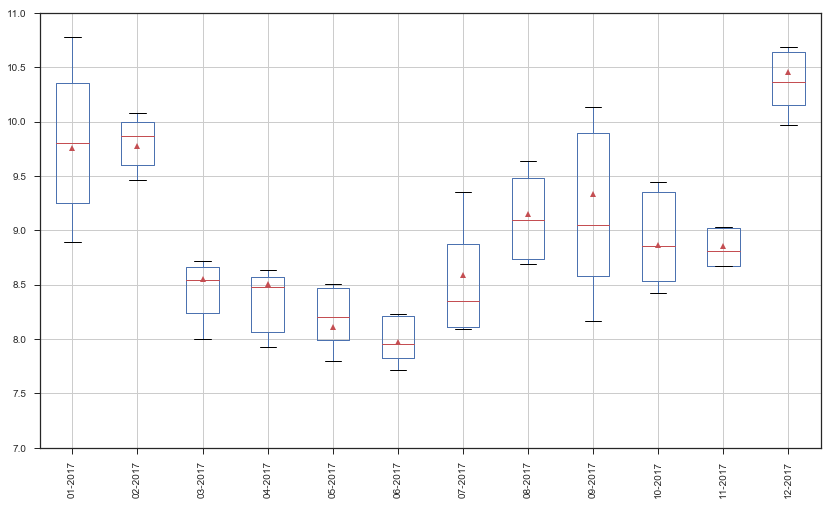

In [42]:
fig, ax = plt.subplots(figsize=a4_dims)

ax = grouped.T.boxplot(whis=[5,95], showmeans=True)

ax.set_xticklabels(labels, rotation='vertical')

ax.set_ylim([7,11])